In [1]:
import pandas as pd
import numpy as np
import random as rnd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
PassengerId = test['PassengerId']

train.dropna(axis=0, subset=['Survived'], inplace=True)
y_train = train.Survived
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

full_data = pd.concat([train, test]).reset_index(drop=True)

In [3]:
full_data.shape

(1309, 11)

In [4]:
full_data.head

<bound method NDFrame.head of       Survived  Pclass                                               Name  \
0          0.0       3                            Braund, Mr. Owen Harris   
1          1.0       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2          1.0       3                             Heikkinen, Miss. Laina   
3          1.0       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4          0.0       3                           Allen, Mr. William Henry   
...        ...     ...                                                ...   
1304       NaN       3                                 Spector, Mr. Woolf   
1305       NaN       1                       Oliva y Ocana, Dona. Fermina   
1306       NaN       3                       Saether, Mr. Simon Sivertsen   
1307       NaN       3                                Ware, Mr. Frederick   
1308       NaN       3                           Peter, Master. Michael J   

         Sex   Age  SibSp  Parch             

In [5]:
full_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [6]:
print(full_data.columns.values)

['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


# ***Data Analysis***

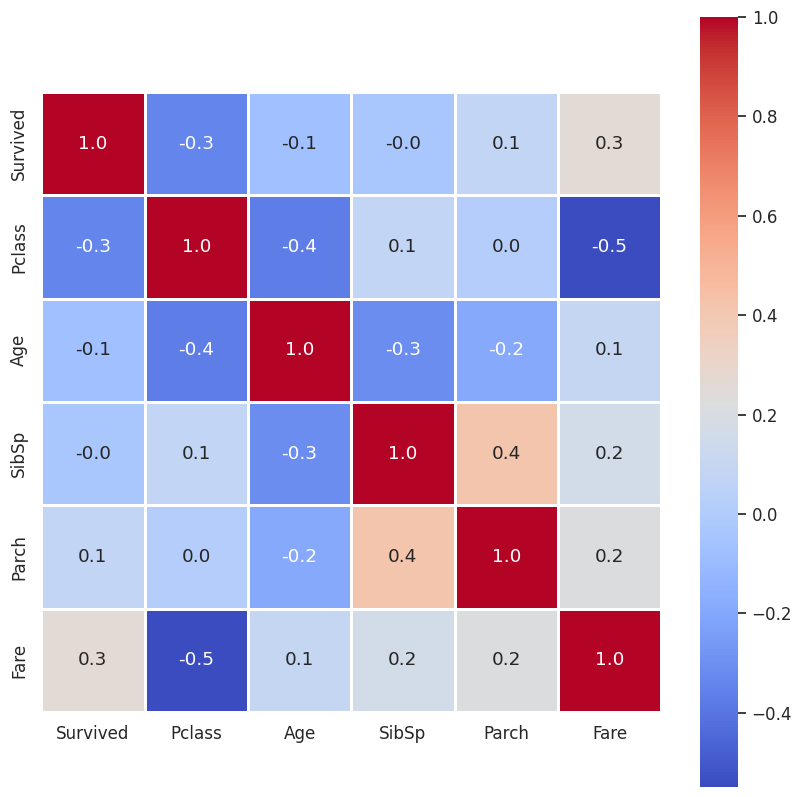

In [7]:
sns.set(font_scale=1.1)
correlation_train = train.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.01f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=True)

plt.show()

In [8]:
train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Analysis of pearson correlation
* Survival is correlated to fare and class. Currently, important factors such as sex are not numerical. They are "M" and "F", not 0 and 1 so we will do these in the feature engineering section.

## Missing Data

In [9]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Cabin,Age,Embarked,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
Total,687.000000,177.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Percent,77.104377,19.865320,0.224467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


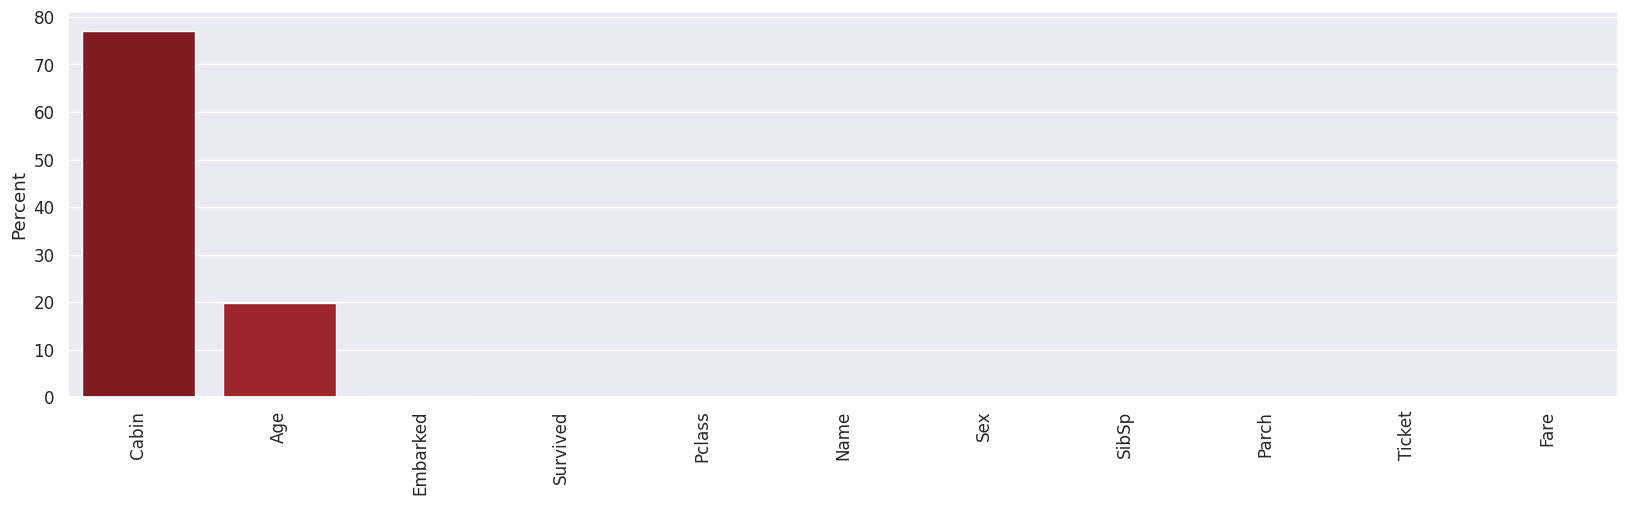

In [10]:
missing = missing_percentage(train)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

<Axes: xlabel='Pclass', ylabel='Age'>

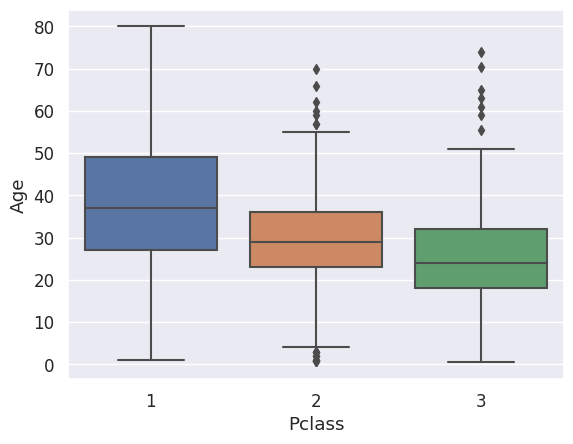

In [11]:
sns.boxplot(x='Pclass',y='Age',data=train)

* Since 'Age' and 'Pclass' are correlated, we can fill the missing values in 'Age' with the mean age corresponding to each 'Pclass'.

In [12]:
mean_age_by_pclass = full_data.groupby('Pclass')['Age'].mean()
print("\nMean Age by Pclass:")
print(mean_age_by_pclass)


Mean Age by Pclass:
Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64


In [13]:
def fill_missing_age(df):
    mean_age_by_pclass = df.groupby('Pclass')['Age'].transform('mean')
    
    df['Age'] = df['Age'].fillna(mean_age_by_pclass)
    
    return df

full_data = fill_missing_age(full_data)

print("\nAfter filling missing values, number of missing 'Age' values:")
print(full_data['Age'].isnull().sum())


After filling missing values, number of missing 'Age' values:
0


* Why would "Embarked" be missing? There's no apparent reason, so let's impute with the most common, "S".

In [14]:
most_common_embarked = full_data['Embarked'].mode()[0]
print("Most common value in 'Embarked':", most_common_embarked)

Most common value in 'Embarked': S


In [15]:
full_data['Embarked'].fillna(most_common_embarked, inplace=True)

print("\nAfter filling missing 'Embarked' values, number of missing 'Embarked' values:")
print(full_data['Embarked'].isnull().sum())


After filling missing 'Embarked' values, number of missing 'Embarked' values:
0


Now we are left with Cabin column.
I'm assuming that if there is no cabin number, then they don't have a cabin. 
So, I will replace Cabin with HasCabin in Feature Engineering part, that says whether they have a cabin or not.

In [16]:
full_data['Fare'].fillna(train['Fare'].median(), inplace=True)

In [17]:
full_data.isnull().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
dtype: int64

# ***Feature Engineering***

* New features

In [18]:
full_data['HasCabin'] = full_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

In [19]:
full_data.isnull().sum()

Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1014
Embarked         0
HasCabin         0
FamilySize       0
IsAlone          0
dtype: int64

* Mapping features

In [20]:
full_data['Sex'] = full_data['Sex'].map({'female': 0, 'male': 1})

full_data['Embarked'] = full_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

full_data.loc[full_data['Fare'] < 7.896, 'Fare'] = 0
full_data.loc[(full_data['Fare'] >= 7.896) & (full_data['Fare'] < 14.454), 'Fare'] = 1
full_data.loc[(full_data['Fare'] >= 14.454) & (full_data['Fare'] < 31.275), 'Fare'] = 2
full_data.loc[full_data['Fare'] >= 31.275, 'Fare'] = 3

* Deleting: Name, Ticket and Cabin

In [21]:
full_data.isnull().sum()

Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         1014
Embarked         0
HasCabin         0
FamilySize       0
IsAlone          0
dtype: int64

In [22]:
full_data.drop(columns=['Ticket', 'Cabin', 'Name'], inplace=True)
full_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,FamilySize,IsAlone
0,0.0,3,1,22.000000,1,0,0.0,0,0,2,0
1,1.0,1,0,38.000000,1,0,3.0,1,1,2,0
2,1.0,3,0,26.000000,0,0,1.0,0,0,1,1
3,1.0,1,0,35.000000,1,0,3.0,0,1,2,0
4,0.0,3,1,35.000000,0,0,1.0,0,0,1,1
5,0.0,3,1,24.816367,0,0,1.0,2,0,1,1
6,0.0,1,1,54.000000,0,0,3.0,0,1,1,1
7,0.0,3,1,2.000000,3,1,2.0,0,0,5,0
8,1.0,3,0,27.000000,0,2,1.0,0,0,3,0
9,1.0,2,0,14.000000,1,0,2.0,1,0,2,0


In [23]:
full_data.isnull().sum()

Survived      418
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
HasCabin        0
FamilySize      0
IsAlone         0
dtype: int64

# Final splitting and checking data

In [24]:
train = full_data.iloc[:len(train), :]
test = full_data.iloc[len(train):, :]

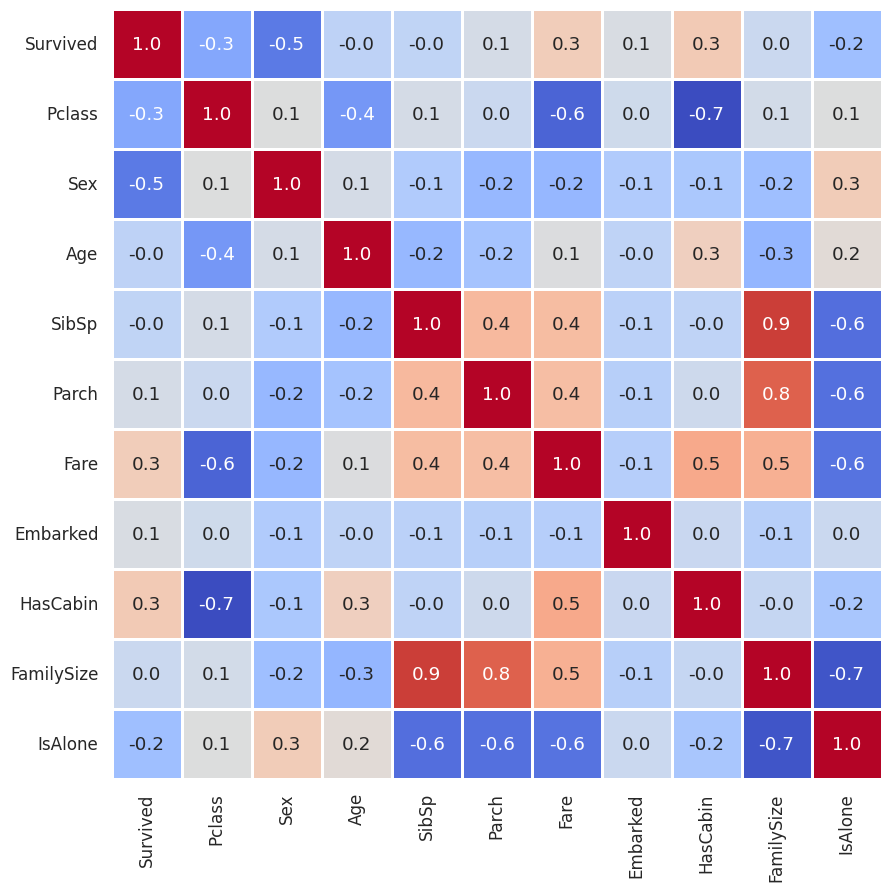

In [25]:
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.01f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=False)

plt.show()

Analysis of pearson correlation
* Sex is the largest determiner of survival.
* Other than that, pclass, fare, cabin, and being alone have a high correlation. 

In [26]:
missing = missing_percentage(train)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,FamilySize,IsAlone
Total,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Percent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
train.drop(['Survived'], axis=1, inplace=True)
test.drop(['Survived'], axis=1, inplace=True)

# Model

In [28]:
model = XGBClassifier(
    n_estimators=200,
    gamma=0.8,
    eta=0.015,
    learning_rate=0.008)
pipeline = Pipeline(steps=[('model', model)])
model.fit(train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.015, eval_metric=None,
              feature_types=None, gamma=0.8, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.008, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
scores = cross_val_score(pipeline, train, y_train,
                              cv=5,
                              scoring='accuracy')

print("Average accuracy score (across experiments):")
print(scores.mean())

Average accuracy score (across experiments):
0.8316489862532169


In [30]:
preds_test = pipeline.predict(test)

output = pd.DataFrame({'PassengerId': PassengerId,
                       'Survived': preds_test})
output.head()
output.to_csv('submission.csv', index=False)